## Jiggle circle
Iterative corrective mechanism to make slightly off circle detections more precise. The refining is done only on the circle's center. Radius is assumed to be correct.

### 1. Imports

In [9]:
import cv2
import numpy as np
from matplotlib import pyplot as plt


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 2. Simple visualization

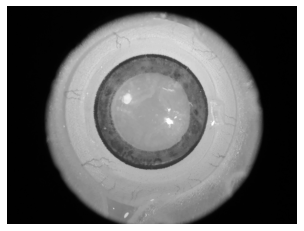

In [10]:
im = cv2.imread('data/artificial/base3.jpeg')
im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

plt.imshow(im, cmap='gray')
plt.axis('off')
plt.show()

### 3. Generating dummy data

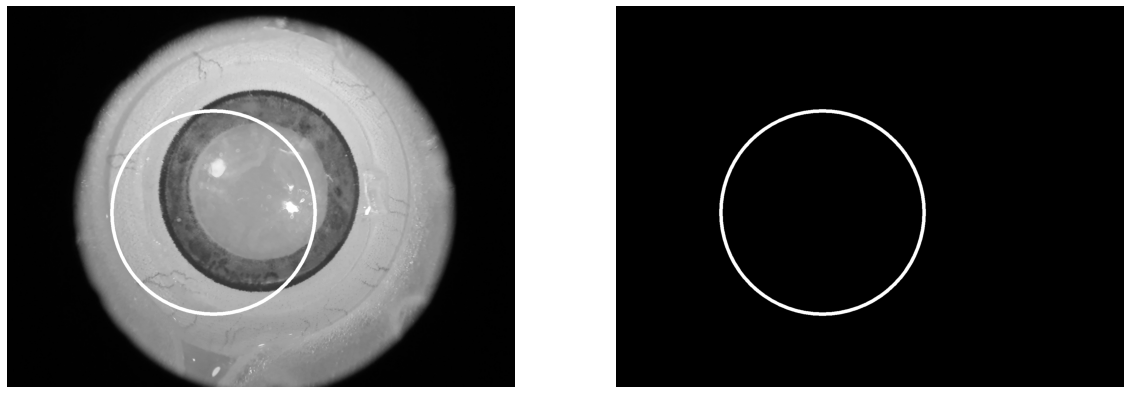

In [11]:
CORRECT_CIRCLE = np.array((800, 580, 320))
INIT_CIRCLE = np.array((650, 650, 320))

im_c = im.copy()
mask = np.zeros(im_c.shape, dtype=np.byte)
cv2.circle(im_c, (INIT_CIRCLE[0], INIT_CIRCLE[1]), INIT_CIRCLE[2], 255, 10)
cv2.circle(mask, (INIT_CIRCLE[0], INIT_CIRCLE[1]), INIT_CIRCLE[2], 1, 10)

_, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(im_c, cmap='gray')
axs[0].axis('off')

axs[1].imshow(mask, cmap='gray')
axs[1].axis('off')

plt.show()

### 4. Image moment computation

In [12]:
moments = cv2.moments(im*mask, False)
moments

{'m00': 3441089.0,
 'm10': 2176975953.0,
 'm01': 2228734503.0,
 'm20': 1555248075335.0,
 'm11': 1411098050474.0,
 'm02': 1616480350963.0,
 'm30': 1214713146258801.0,
 'm21': 1006426181596194.0,
 'm12': 1024699425053238.0,
 'm03': 1274142081328689.0,
 'mu20': 178002587078.1548,
 'mu11': 1107951801.0488281,
 'mu02': 172967124521.4121,
 'mu30': 5574886761388.75,
 'mu21': -2283274939045.5,
 'mu12': 611552476629.6719,
 'mu03': 3119702011000.75,
 'nu20': 0.015032613921099999,
 'nu11': 9.356836853748431e-05,
 'nu02': 0.014607360750501798,
 'nu30': 0.00025380272870614184,
 'nu21': -0.00010394855262884998,
 'nu12': 2.7841585660646627e-05,
 'nu03': 0.00014202779662286582}

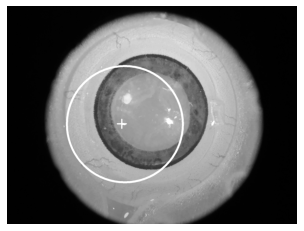

In [13]:
center = (round(moments['m10']/moments['m00']),
          round(moments['m01']/moments['m00']))
direction = (round(moments['m10']/moments['m00'] - INIT_CIRCLE[0]),
             round(moments['m01']/moments['m00'] - INIT_CIRCLE[1]))
im_cc = im_c.copy()
cv2.drawMarker(im_cc, center, 255, thickness=5, markerSize=50)
cv2.line(im_cc, (INIT_CIRCLE[0], INIT_CIRCLE[1]), center, 255, thickness=10)

plt.imshow(im_cc, cmap='gray')
plt.axis('off')
plt.show()

### 5. Iterative correcting

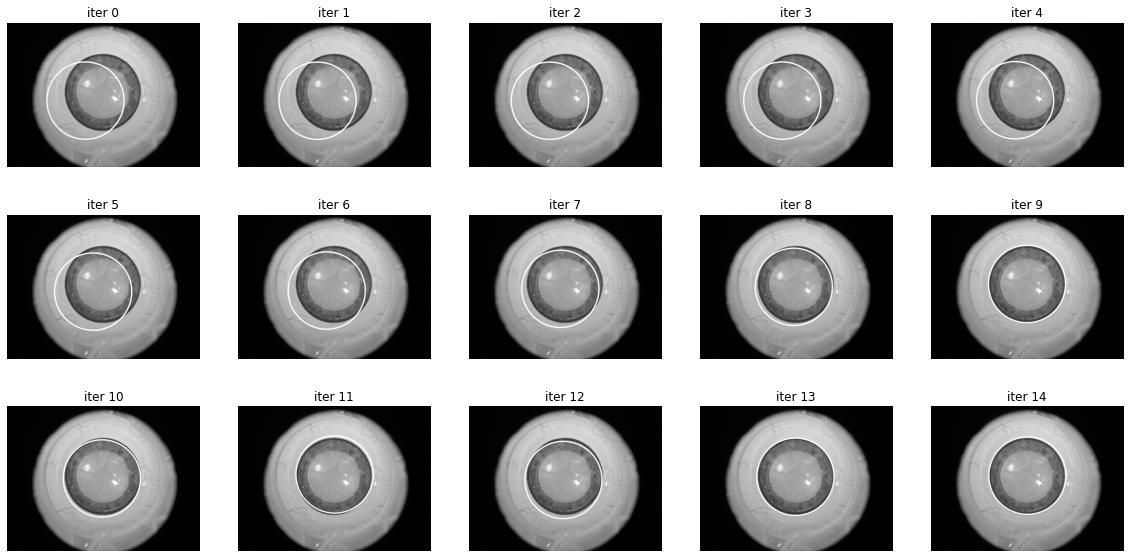

correct  [800 580 320] 
detected  [799.32196 576.0296  320.     ]


In [14]:
MAX_ITER = 15
ALPHA = 0.5

iter_ims = [im_c]
circle = np.copy(INIT_CIRCLE).astype('float32')
for _ in range(MAX_ITER - 1):
    # pre edge treatment
    mask = np.zeros(im_c.shape, dtype=np.byte)
    cv2.circle(mask, (round(circle[0]), round(
        circle[1])), round(circle[2]), 1, 10)
    moments = cv2.moments(im*mask, False)

    # edge treatment
    padding = 0
    im_border = None
    if ((0 < round(circle[0]) - round(circle[2]) - 5) or
        (round(circle[0]) + round(circle[2]) + 5 >= im_c.shape[1]) or
        (0 < round(circle[1]) - round(circle[2]) - 5) or
            (round(circle[1]) + round(circle[2]) + 5 >= im_c.shape[0])):

        mean_value = moments['m00']/cv2.countNonZero(mask)
        padding = round(circle[2])*2 + 10
        im_border = cv2.copyMakeBorder(im, padding, padding, padding, padding,
                                       cv2.BORDER_CONSTANT, value=round(mean_value))
        mask = np.zeros(im_border.shape, dtype=np.byte)
        cv2.circle(mask, (round(
            circle[0]) + padding, round(circle[1]) + padding), round(circle[2]), 1, 10)
        moments = cv2.moments(im_border*mask, False)

    # post edge treatment
    direction = np.array((moments['m10']/moments['m00'] - circle[0] - padding,
                          moments['m01']/moments['m00'] - circle[1] - padding))
    circle[:2] -= ALPHA*direction

    im_new = im.copy()
    cv2.circle(im_new, (round(circle[0]), round(
        circle[1])), round(circle[2]), 255, 10)
    iter_ims.append(im_new)

_, axs = plt.subplots(int(np.ceil(len(iter_ims)/5)), 5, figsize=(20, 10))
for i in range(len(iter_ims)):
    axs[i//5, i % 5].set_title('iter %d' % i)
    axs[i//5, i % 5].imshow(iter_ims[i], cmap='gray')
    axs[i//5, i % 5].axis('off')

plt.show()
print('correct ', CORRECT_CIRCLE, '\ndetected ', circle)